### SUR échantillonnage

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
import numpy as np


# Charger le fichier mis à jour
df = pd.read_csv('data/all_data_for_users_with_anomalies.csv')

# Calculer le nombre total d'utilisateurs uniques
total_users = df['user_number'].nunique()

print(f"Nombre total d'utilisateurs : {total_users}")


Nombre total d'utilisateurs : 68


In [6]:
df

,user_number,datetime,Consommation,cluster,anomalie,type
0,0_39,2016-03-01 01:02:47,7,0,0,pas d'anomalie
1,0_39,2016-03-01 02:02:47,8,0,0,pas d'anomalie
2,0_39,2016-03-01 03:02:45,3,0,0,pas d'anomalie
3,0_39,2016-03-01 04:02:45,0,0,0,pas d'anomalie
4,0_39,2016-03-01 05:02:45,0,0,0,pas d'anomalie
...,...,...,...,...,...,...
319104,2_75,2017-02-12 19:53:03,0,2,0,pas d'anomalie
319105,2_75,2017-02-12 20:53:03,0,2,0,pas d'anomalie
319106,2_75,2017-02-12 21:53:02,0,2,0,pas d'anomalie
319107,2_75,2017-02-12 22:53:02,0,2,0,pas d'anomalie


In [7]:
# Iterate through each cluster
clusters = df['cluster'].unique()
balanced_data = []

for cluster in clusters:
    print(f"Processing cluster {cluster}...")
    
    # Filter data for the current cluster
    cluster_data = df[df['cluster'] == cluster]
    
    # Separate 'pas d'anomalie' (majority class) from the rest
    pas_anomalie = cluster_data[cluster_data['type'] == "pas d'anomalie"]
    anomalies = cluster_data[cluster_data['type'] != "pas d'anomalie"]
    
    # Encode the anomaly types as numeric labels for SMOTE
    anomalies['type_encoded'] = anomalies['type'].factorize()[0]
    type_mapping = dict(enumerate(anomalies['type'].unique()))  # Save mapping for later
    
    # Apply SMOTE only on the anomalies
    smote = SMOTE(random_state=42)
    X = anomalies[['Consommation']]  # Features to oversample
    y = anomalies['type_encoded']    # Labels for oversampling
    
    X_smote, y_smote = smote.fit_resample(X, y)
    
    # Decode the labels back to original anomaly types
    smote_data = pd.DataFrame(X_smote, columns=['Consommation'])
    smote_data['type'] = y_smote.map(lambda x: type_mapping[x])
    smote_data['user_number'] = np.random.choice(pas_anomalie['user_number'].unique(), size=len(smote_data))  # Assign users randomly
    smote_data['cluster'] = cluster
    smote_data['datetime'] = pd.date_range(start=pas_anomalie['datetime'].min(), periods=len(smote_data), freq='H')  # Generate synthetic datetimes
    
    # Combine the SMOTE-generated anomalies with 'pas d'anomalie' data
    cluster_balanced_data = pd.concat([pas_anomalie, smote_data], axis=0)
    
    # Append to the overall balanced dataset
    balanced_data.append(cluster_balanced_data)

# Combine all clusters into a single balanced dataset
balanced_df = pd.concat(balanced_data, axis=0)

# Save the balanced dataset
balanced_df.to_csv('data/balanced_data.csv', index=False)
print("Balanced dataset saved to 'data/balanced_data.csv'")

Processing cluster 0...
Processing cluster 1...
Processing cluster 2...


C:\Users\MSI\AppData\Local\Temp\ipykernel_26512\1063349713.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anomalies['type_encoded'] = anomalies['type'].factorize()[0]
C:\Users\MSI\AppData\Local\Temp\ipykernel_26512\1063349713.py:31: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  smote_data['datetime'] = pd.date_range(start=pas_anomalie['datetime'].min(), periods=len(smote_data), freq='H')  # Generate synthetic datetimes
C:\Users\MSI\AppData\Local\Temp\ipykernel_26512\1063349713.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydat

Balanced dataset saved to 'data/balanced_data.csv'


In [9]:

# Charger le fichier mis à jour
df1 = pd.read_csv('data/balanced_data.csv')

# Calculer le nombre total d'utilisateurs uniques
total_users = df1['user_number'].nunique()

print(f"Nombre total d'utilisateurs : {total_users}")

Nombre total d'utilisateurs : 68


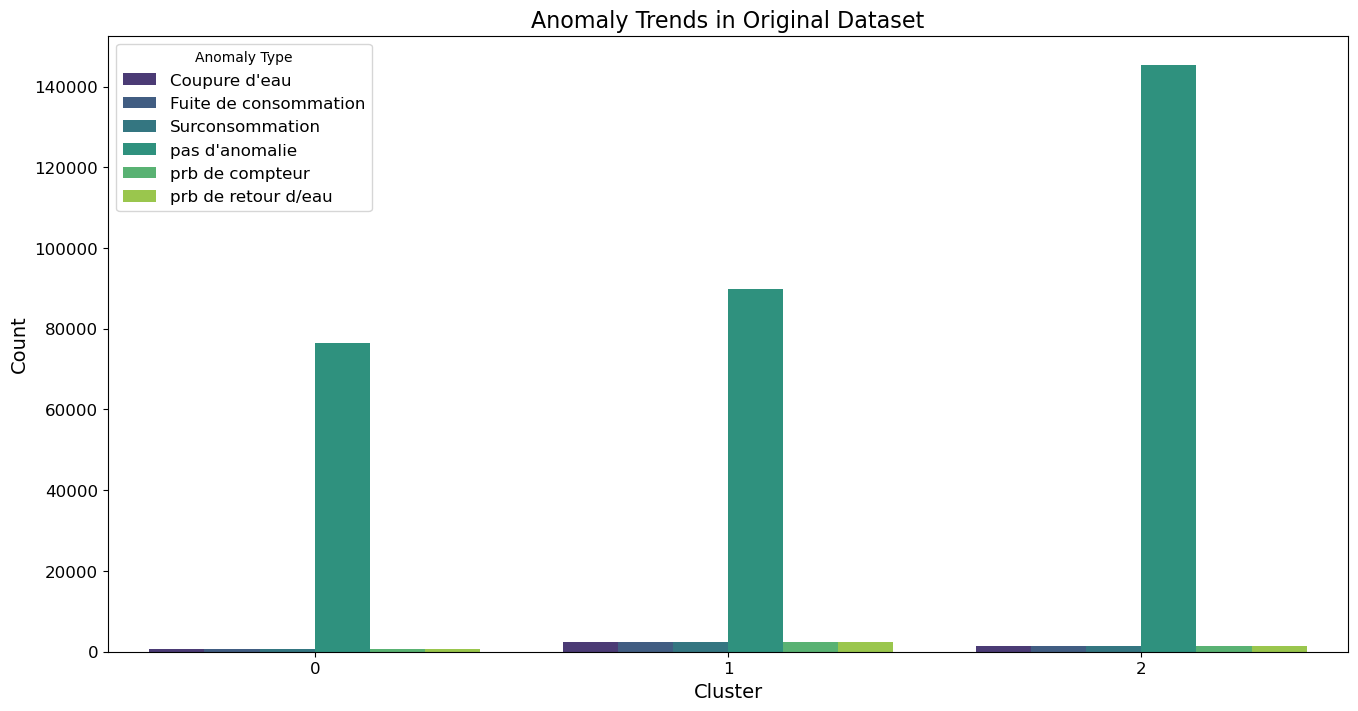

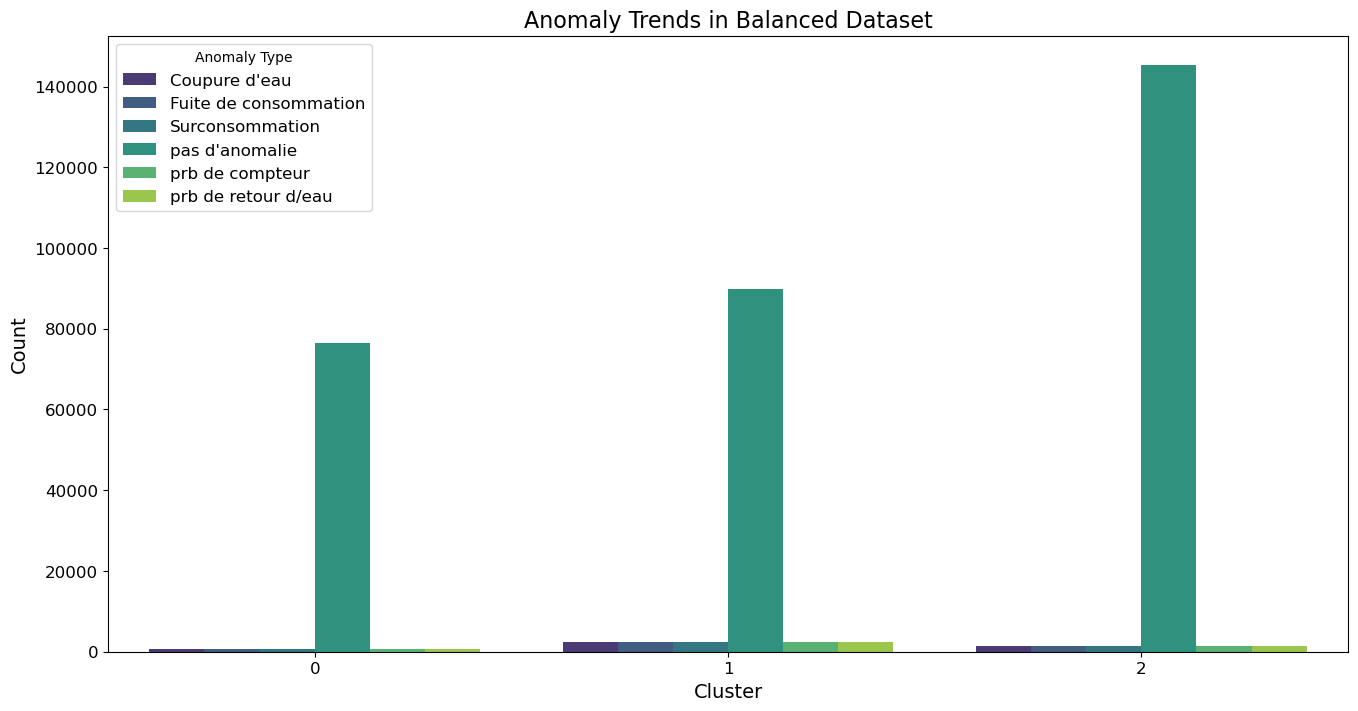

In [10]:
# Define a function for visualizing trends
def plot_anomaly_trends(data, title):
    plt.figure(figsize=(16, 8))
    
    # Count the number of each type of anomaly per cluster
    cluster_anomaly_counts = data.groupby(['cluster', 'type']).size().reset_index(name='count')
    
    # Plot the trends as a bar plot
    sns.barplot(x='cluster', y='count', hue='type', data=cluster_anomaly_counts, palette='viridis')
    
    # Add plot details
    plt.title(title, fontsize=16)
    plt.xlabel('Cluster', fontsize=14)
    plt.ylabel('Count', fontsize=14)
    plt.legend(title='Anomaly Type', fontsize=12)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.show()

# Plot the original data
plot_anomaly_trends(df, "Anomaly Trends in Original Dataset")

# Plot the balanced data
plot_anomaly_trends(df1, "Anomaly Trends in Balanced Dataset")

In [14]:
import pandas as pd

# Load the datasets
df1 = pd.read_csv('data/balanced_data.csv')  # Balanced dataset
df = pd.read_csv('data/all_data_for_users_with_anomalies.csv')  # Original dataset

# Define a function to count anomalies per cluster
def count_anomalies(data, dataset_name):
    print(f"--- Anomaly Counts in {dataset_name} ---")
    
    # Group by 'cluster' and 'type', count the occurrences
    anomaly_counts = data.groupby(['cluster', 'type']).size().reset_index(name='count')
    
    # Print the results
    for cluster in sorted(data['cluster'].unique()):
        print(f"\nCluster {cluster}:")
        cluster_data = anomaly_counts[anomaly_counts['cluster'] == cluster]
        for _, row in cluster_data.iterrows():
            print(f"  {row['type']}: {row['count']}")




In [15]:
# Count anomalies in the original dataset
count_anomalies(df, "Original Dataset")

--- Anomaly Counts in Original Dataset ---

Cluster 0:
  Coupure d'eau: 422
  Fuite de consommation: 266
  Surconsommation: 81
  pas d'anomalie: 76380
  prb de compteur: 9
  prb de retour d/eau: 579

Cluster 1:
  Coupure d'eau: 2464
  Fuite de consommation: 769
  Surconsommation: 36
  pas d'anomalie: 89835
  prb de compteur: 18
  prb de retour d/eau: 150

Cluster 2:
  Coupure d'eau: 1154
  Fuite de consommation: 1343
  Surconsommation: 193
  pas d'anomalie: 145320
  prb de compteur: 65
  prb de retour d/eau: 25


In [16]:
# Count anomalies in the balanced dataset
count_anomalies(df1, "Balanced Dataset")

--- Anomaly Counts in Balanced Dataset ---

Cluster 0:
  Coupure d'eau: 579
  Fuite de consommation: 579
  Surconsommation: 579
  pas d'anomalie: 76380
  prb de compteur: 579
  prb de retour d/eau: 579

Cluster 1:
  Coupure d'eau: 2464
  Fuite de consommation: 2464
  Surconsommation: 2464
  pas d'anomalie: 89835
  prb de compteur: 2464
  prb de retour d/eau: 2464

Cluster 2:
  Coupure d'eau: 1343
  Fuite de consommation: 1343
  Surconsommation: 1343
  pas d'anomalie: 145320
  prb de compteur: 1343
  prb de retour d/eau: 1343
